In [15]:
import logging
import os
import re

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

os.environ["TOKENIZERS_PARALLELISM"] = "false"


nltk.download("stopwords")
from nltk.corpus import stopwords

russian_stopwords = stopwords.words("russian")  # для очистки текста

import torch
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from transformers import AutoModel, AutoTokenizer

# Настройка логирования и стиля
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)
sns.set(style="whitegrid")

[nltk_data] Downloading package stopwords to /home/vadim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
####################################
# Трансформер очистки текста
####################################
class TextCleanerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def clean_text(text):
            if not isinstance(text, str):
                return ""
            text = text.lower()
            text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
            text = re.sub(r"\W+", " ", text)
            text = re.sub(r"\s+", " ", text).strip()
            return text

        return X.apply(clean_text)


####################################
# Трансформер для извлечения эмбеддингов с использованием BERT (батчами, max_length=512)
####################################
class BertVectorizer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        model_name="bert-base-multilingual-cased",
        max_length=512,
        batch_size=32,
        device="cuda:1",
    ):
        self.model_name = model_name
        self.max_length = max_length
        self.batch_size = batch_size
        self.device = (
            device
            if device is not None
            else ("cuda" if torch.cuda.is_available() else "cpu")
        )

    def fit(self, X, y=None):
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name)
        self.model.to(self.device)
        self.model.eval()
        return self

    def transform(self, X):
        texts = list(X)
        embeddings = []
        with torch.no_grad():
            for i in tqdm(
                range(0, len(texts), self.batch_size), desc="Извлечение эмбеддингов"
            ):
                batch_texts = texts[i : i + self.batch_size]
                encoded = self.tokenizer(
                    batch_texts,
                    truncation=True,
                    max_length=self.max_length,
                    padding="max_length",
                    return_tensors="pt",
                )
                encoded = {k: v.to(self.device) for k, v in encoded.items()}
                output = self.model(**encoded)
                # Используем представление CLS-токена
                batch_emb = output.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.append(batch_emb)
        return np.concatenate(embeddings, axis=0)


####################################
# Функции для выбора колонок из DataFrame
####################################
# Для извлечения исходного текста из нужной колонки
def select_column(col_name):
    return lambda X: X[col_name]


####################################
# Пайплайны для извлечения эмбеддингов для каждой колонки
####################################
# Pipeline для subject
subject_bert_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_column("subject"), validate=False)),
        # ("cleaner", TextCleanerTransformer()),
        (
            "bert",
            BertVectorizer(
                model_name="bert-base-multilingual-cased", max_length=512, batch_size=32
            ),
        ),
    ]
)
# Pipeline для description
description_bert_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_column("description"), validate=False)),
        # ("cleaner", TextCleanerTransformer()),
        (
            "bert",
            BertVectorizer(
                model_name="bert-base-multilingual-cased", max_length=512, batch_size=32
            ),
        ),
    ]
)
# Pipeline для abstract
abstract_bert_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_column("abstract"), validate=False)),
        # ("cleaner", TextCleanerTransformer()),
        (
            "bert",
            BertVectorizer(
                model_name="bert-base-multilingual-cased", max_length=512, batch_size=32
            ),
        ),
    ]
)

####################################
# Загрузка данных
####################################
logger.info("Загрузка данных...")
# Предполагается, что файл содержит колонки: subject, description, abstract, class
data = pd.read_csv("../data/pocessed_1/df.csv")
data["subject"] = data["subject"].fillna("no_subject")
data["description"] = data["description"].fillna("no_description")
# data["abstract"] = data["abstract"].fillna("no_abstract")
X_raw = data[["subject", "description"]]
y = data["class"]

####################################
# Извлечение эмбеддингов (один раз)
####################################
logger.info("Извлечение эмбеддингов для subject...")
subject_embeddings = subject_bert_pipeline.fit_transform(X_raw)
logger.info("Извлечение эмбеддингов для description...")
description_embeddings = description_bert_pipeline.fit_transform(X_raw)
logger.info("Извлечение эмбеддингов для abstract...")
# abstract_embeddings = abstract_bert_pipeline.fit_transform(X_raw)

####################################
# Формирование наборов признаков для экспериментов
####################################
# 1. Только subject
X_subject = subject_embeddings
# 2. Только description
X_description = description_embeddings
# 3. Только abstract
# X_abstract = abstract_embeddings
# 4. Комбинация: subject + description
X_subj_desc = np.concatenate([subject_embeddings, description_embeddings], axis=1)
# 5. Комбинация: subject + abstract
# X_subj_abst = np.concatenate([subject_embeddings

In [7]:
import faiss
import numpy as np
import pandas as pd

# Предполагается, что исходные данные:
# data – DataFrame с колонкой "description"
# y – метки классов (массив или Series)
# description_embeddings – numpy-массив эмбеддингов (соответствуют строкам data)

# Фильтруем строки, где description равен "no_description"
mask = data["description"] != "no_description"
data_filtered = data[mask].reset_index(drop=True)
description_embeddings_filtered = description_embeddings[mask]
# Если y – numpy-массив, можно фильтровать так:
y_filtered = np.array(y)[mask]

# Используем отфильтрованные данные для поиска
df = data_filtered.copy()
y = y_filtered

# Получаем уникальные классы для многоклассовой классификации
unique_classes = np.unique(y)


# Функция поиска ближайших соседей с использованием FAISS
def search_opposite_class(query_embeddings, target_embeddings, topk=1):
    d = target_embeddings.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(target_embeddings)
    distances, indices = index.search(query_embeddings, topk)
    return distances, indices


# Количество ближайших соседей для поиска
topk = 5

results = []

# Для каждого класса рассматриваем формат "1 vs All":
for cls in unique_classes:
    # Выбираем индексы для текущего класса (запросы) и всех остальных (целевая группа)
    query_indices = np.where(y == cls)[0]
    target_indices = np.where(y != cls)[0]

    # Получаем эмбеддинги для запросов и для кандидатов
    query_embeddings = description_embeddings_filtered[query_indices]
    target_embeddings = description_embeddings_filtered[target_indices]

    logger.info(
        "Поиск похожих эмбеддингов для класса {} против всех остальных".format(cls)
    )
    distances, candidate_local_indices = search_opposite_class(
        query_embeddings, target_embeddings, topk=topk
    )

    # Преобразуем локальные индексы кандидатов в глобальные индексы
    for i, (dist_row, cand_indices) in enumerate(
        zip(distances, candidate_local_indices)
    ):
        query_global_idx = query_indices[i]
        global_cand_indices = [target_indices[cand] for cand in cand_indices]
        results.append((query_global_idx, global_cand_indices, dist_row.tolist()))

# Сортируем результаты по расстоянию первого кандидата (наименьшее расстояние = наиболее похожие)
results_sorted = sorted(results, key=lambda x: x[2][0])

# Собираем результаты в DataFrame для удобства анализа
res_data = []
for query_idx, cand_list, dist_list in results_sorted:
    for cand_idx, dist in zip(cand_list, dist_list):
        query_text = df.loc[query_idx, "description"]
        candidate_text = df.loc[cand_idx, "description"]
        query_class = y[query_idx]
        candidate_class = y[cand_idx]
        res_data.append(
            {
                "query_idx": query_idx,
                "candidate_idx": cand_idx,
                "distance": dist,
                "query_text": query_text,
                "candidate_text": candidate_text,
                "query_class": query_class,
                "candidate_class": candidate_class,
            }
        )

results_df = pd.DataFrame(res_data)

# Сохраняем результаты в CSV-файл
output_results_path = "../results/most_similar_multiclass_1vsall.csv"
results_df.to_csv(output_results_path, index=False)
logger.info(f"Результаты поиска похожих эмбеддингов сохранены в {output_results_path}")

# Выводим топ-10 наиболее похожих пар (с наименьшими расстояниями)
print("Топ-10 наиболее похожих пар (по описанию):")
print(results_df.sort_values("distance").head(10).to_string(index=False))


2025-02-28 18:27:20,059 - INFO - Поиск похожих эмбеддингов для класса Национальный проект "Демография" против всех остальных
2025-02-28 18:27:20,062 - INFO - Поиск похожих эмбеддингов для класса Приемная кампания против всех остальных
2025-02-28 18:27:20,065 - INFO - Поиск похожих эмбеддингов для класса Сопровождение корпоративных сервисов против всех остальных
2025-02-28 18:27:20,073 - INFO - Поиск похожих эмбеддингов для класса Сопровождение мероприятий и учебного процесса против всех остальных
2025-02-28 18:27:20,079 - INFO - Поиск похожих эмбеддингов для класса Сопровождение сервисов 1С против всех остальных
2025-02-28 18:27:20,097 - INFO - Поиск похожих эмбеддингов для класса Сопровождение сервисов Яндекс 360 против всех остальных
2025-02-28 18:27:20,100 - INFO - Поиск похожих эмбеддингов для класса Сопровождение сервисов обучающихся против всех остальных
2025-02-28 18:27:20,104 - INFO - Поиск похожих эмбеддингов для класса Сопровождение сервисов сотрудника против всех остальных
2

Топ-10 наиболее похожих пар (по описанию):
 query_idx  candidate_idx  distance                                                                                                                                                                                                                                                                                                                                          query_text                                                                                                                                                                                                                                                                                                                                      candidate_text                          query_class                      candidate_class
       936           1384  0.386017                   Добрый день!\n \nНе получается согласовать письмо в Директум, выдаёт ошибку (скрин во вложении).\n\nС уважением,\

In [69]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

scorer = make_scorer(f1_score, average="macro")
# Далее используйте scorer в GridSearchCV или cross_val_score

####################################
# Функция для проведения эксперимента
####################################


def run_experiment(X_emb, y, exp_name="Experiment"):
    X_train, X_test, y_train, y_test = train_test_split(
        X_emb, y, test_size=0.2, random_state=42
    )
    param_grid_rf = {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
    }
    clf = RandomForestClassifier(n_jobs=3, random_state=42)
    grid = RandomizedSearchCV(
        clf,
        param_grid_rf,
        cv=5,
        scoring="f1_macro",
        n_jobs=5,
        verbose=1,
        n_iter=30,
        random_state=42,
    )
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)
    print(f"=== Отчёт по классификации ({exp_name}) ===")
    print(classification_report(y_test, y_pred))
    # roc_auc = roc_auc_score(y_test, probas[:, 1])
    # logger.info(f"{exp_name} - ROC AUC: {roc_auc}")
    return grid.best_estimator_, X_test, y_test, y_pred, y_proba


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix


def run_eval(best_estimator, X_test, y_test, y_pred, y_proba, exp_name="Experiment"):
    """
    Функция для визуализации результатов эксперимента.
    Визуализирует распределение предсказанных вероятностей по классам
    и матрицу ошибок.

    Аргументы:
      best_estimator: обученная модель с атрибутом classes_
      X_test: тестовая выборка признаков
      y_test: истинные метки для тестовой выборки
      y_pred: предсказанные метки
      y_proba: предсказанные вероятности (numpy-массив, shape=(n_samples, n_classes))
      exp_name: название эксперимента (для заголовков графиков)
    """
    # Извлекаем список классов (предполагается, что порядок столбцов в y_proba соответствует best_estimator.classes_)
    classes = best_estimator.classes_

    # Создаем DataFrame с вероятностями, добавляя истинную метку
    df_probs = pd.DataFrame(y_proba, columns=classes)
    df_probs["true_label"] = y_test

    # # Визуализация распределения вероятностей для каждого класса
    # plt.figure(figsize=(14, 8))
    # for cls in classes:
    #     # График для всех объектов: распределение вероятностей для класса cls
    #     sns.kdeplot(df_probs[cls], label=f"{cls} (all)", shade=True)
    #     # График для объектов, истинная метка которых равна текущему классу
    #     sns.kdeplot(
    #         df_probs[df_probs["true_label"] == cls][cls],
    #         label=f"{cls} (true)",
    #         linestyle="--",
    #     )
    # plt.title(f"Распределение вероятностей по классам ({exp_name})")
    # plt.xlabel("Вероятность")
    # plt.ylabel("Плотность")
    # plt.legend()
    # plt.show()

    # Визуализация матрицы ошибок
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    # plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes
    )
    plt.title(f"Матрица ошибок ({exp_name})")
    plt.xlabel("Предсказанная метка")
    plt.ylabel("Истинная метка")
    plt.show()


####################################
# Проведение экспериментов
####################################
logger.info("Эксперимент 1: Только subject")
best_model_subject, X_test, y_test, y_pred, y_proba = run_experiment(
    X_subject, y, exp_name="Subject-only"
)

2025-02-28 19:33:49,096 - INFO - Эксперимент 1: Только subject


Fitting 5 folds for each of 30 candidates, totalling 150 fits
=== Отчёт по классификации (Subject-only) ===
                                      precision    recall  f1-score   support

                              Другое       0.70      0.22      0.33        32
Сопровождение корпоративных сервисов       0.89      0.59      0.71        54
           Сопровождение сервисов 1С       0.73      0.91      0.81       161
   Сопровождение сервисов сотрудника       0.83      0.84      0.84       153

                            accuracy                           0.79       400
                           macro avg       0.79      0.64      0.67       400
                        weighted avg       0.79      0.79      0.77       400



In [ ]:
sns.kdeplot()

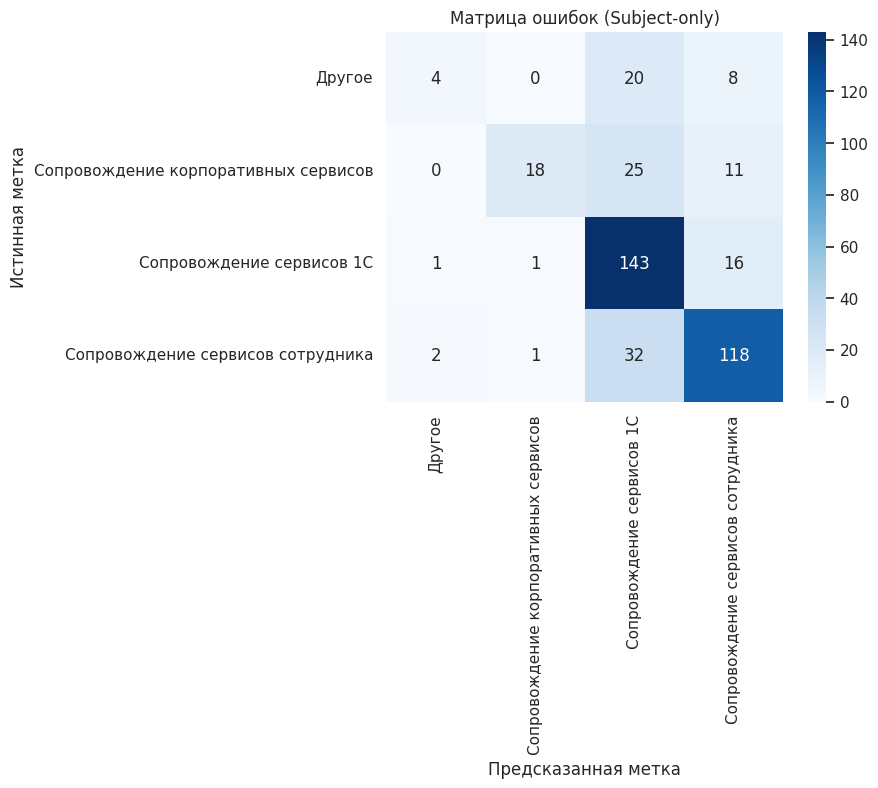

In [52]:
run_eval(best_model_subject, X_test, y_test, y_pred, y_proba, exp_name="Subject-only")

In [53]:
logger.info("Эксперимент 2: Только description")
best_model_description, X_test, y_test, y_pred, y_proba = run_experiment(
    X_description, y, exp_name="Description-only"
)

# logger.info("Эксперимент 3: Только abstract")
# best_model_abstract = run_experiment(X_abstract, y, exp_name="Abstract-only")

2025-02-28 19:00:50,823 - INFO - Эксперимент 2: Только description


Fitting 5 folds for each of 30 candidates, totalling 150 fits
=== Отчёт по классификации (Description-only) ===
                                      precision    recall  f1-score   support

                              Другое       1.00      0.19      0.32        32
Сопровождение корпоративных сервисов       0.89      0.15      0.25        54
           Сопровождение сервисов 1С       0.63      0.86      0.73       161
   Сопровождение сервисов сотрудника       0.67      0.72      0.69       153

                            accuracy                           0.66       400
                           macro avg       0.80      0.48      0.50       400
                        weighted avg       0.71      0.66      0.62       400



2025-02-28 19:35:07,197 - INFO - Эксперимент 4: Subject + Description


Fitting 5 folds for each of 30 candidates, totalling 150 fits
=== Отчёт по классификации (Subject+Description) ===
                                      precision    recall  f1-score   support

                              Другое       0.88      0.22      0.35        32
Сопровождение корпоративных сервисов       0.91      0.57      0.70        54
           Сопровождение сервисов 1С       0.81      0.94      0.87       161
   Сопровождение сервисов сотрудника       0.81      0.91      0.86       153

                            accuracy                           0.82       400
                           macro avg       0.85      0.66      0.70       400
                        weighted avg       0.83      0.82      0.80       400



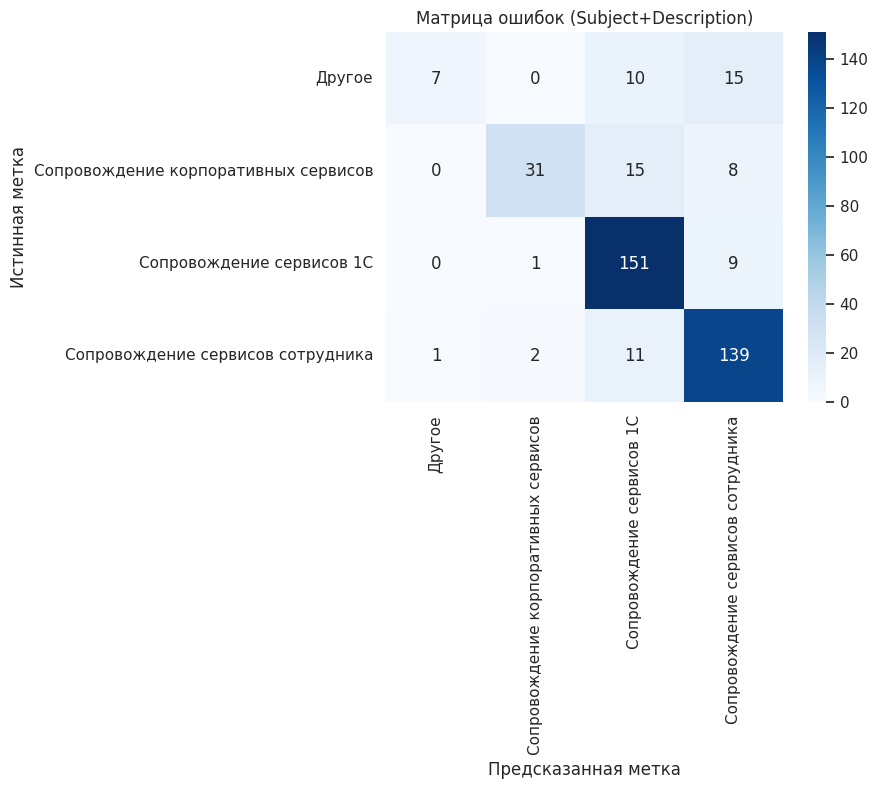

In [70]:
logger.info("Эксперимент 4: Subject + Description")
best_model_subj_desc, X_test, y_test, y_pred, y_proba = run_experiment(
    X_subj_desc, y, exp_name="Subject+Description"
)
run_eval(
    best_model_subj_desc,
    X_test,
    y_test,
    y_pred,
    y_proba,
    exp_name="Subject+Description",
)
# logger.info("Эксперимент 5: Subject + Abstract")
# best_model_subj_abst = run_experiment(X_subj_abst, y, exp_name="Subject+Abstract")

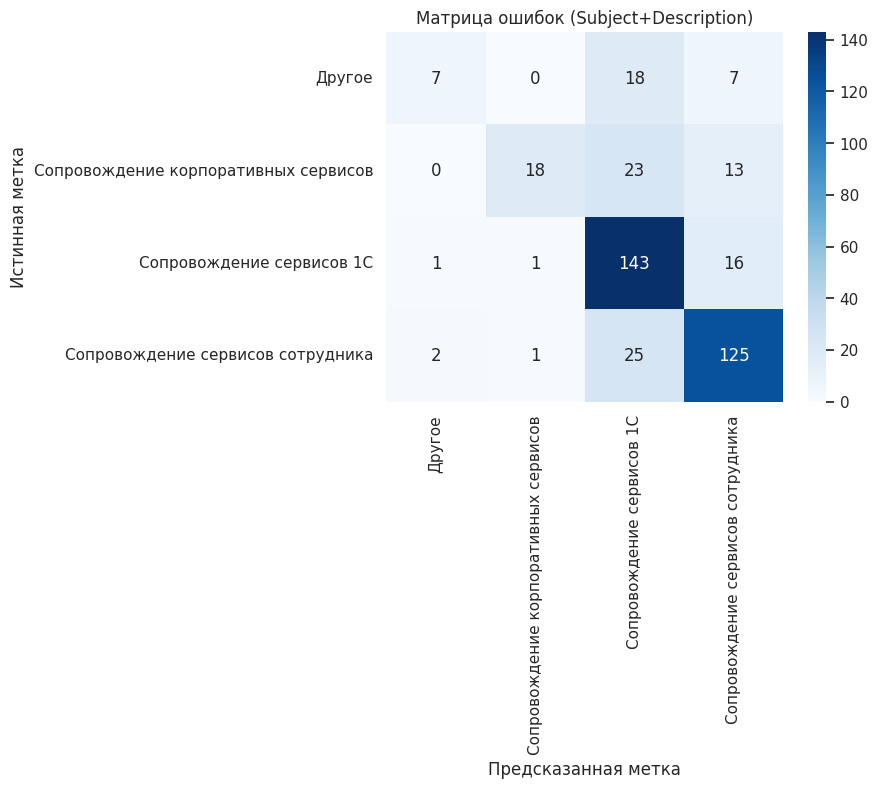

In [55]:
run_eval(
    best_model_subj_desc,
    X_test,
    y_test,
    y_pred,
    y_proba,
    exp_name="Subject+Description",
)

In [26]:
# Извлекаем список классов (предполагается, что порядок столбцов в y_proba соответствует best_estimator.classes_)
classes = best_model_subj_desc.classes_

# Создаем DataFrame с вероятностями, добавляя истинную метку
df_probs = pd.DataFrame(y_proba, columns=classes)
df_probs["true_label"] = y_test.values

for name in classes:
    sns.histplot(df_probs, x=name, hue="true_label")
    plt.show()

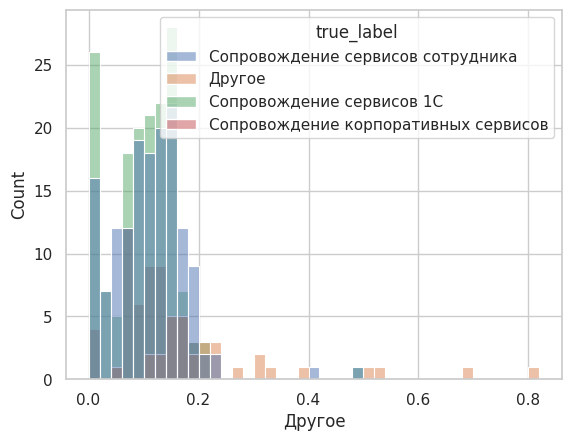

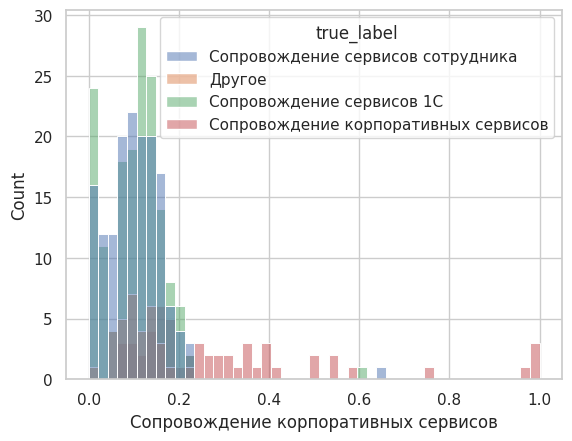

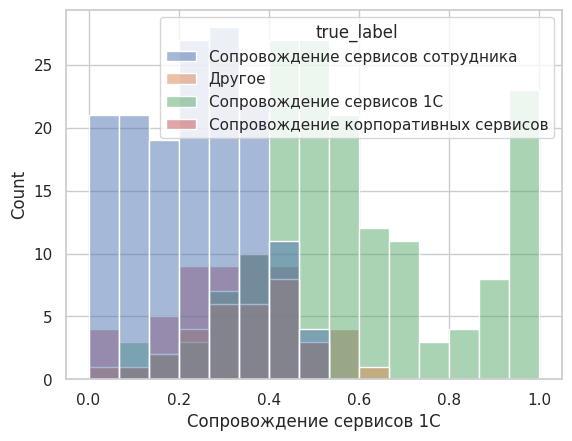

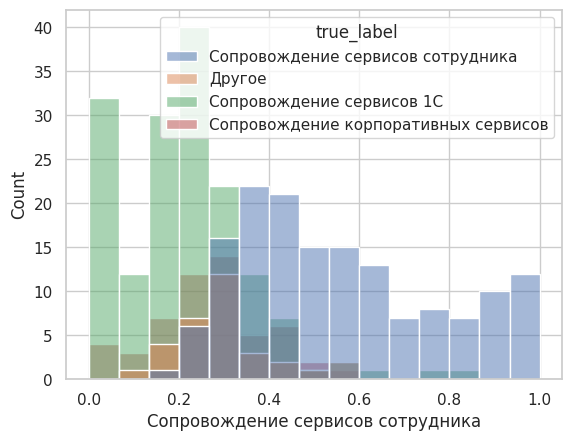

In [37]:
import numpy as np
from sklearn.metrics import roc_curve


def find_thresholds(y_true, y_proba, classes):
    """
    Для каждой метки класса находит порог, при котором
    полнота (tpr) равна 1 (то есть все истинные примеры имеют вероятность ≥ порога).

    Аргументы:
        y_true: массив истинных меток
        y_proba: numpy-массив предсказанных вероятностей, shape=(n_samples, n_classes)
        classes: список уникальных классов (порядок столбцов в y_proba должен соответствовать этому списку)

    Возвращает:
        thresholds: словарь, где для каждого класса указан выбранный порог
    """
    thresholds = {}
    for i, cls in enumerate(classes):
        # Бинарные метки: 1 для примеров, принадлежащих текущему классу, иначе 0
        y_true_bin = (y_true == cls).astype(int)
        fpr, tpr, thresh = roc_curve(y_true_bin, y_proba[:, i])
        # Найдем первый порог, при котором tpr достигает 1 (то есть все положительные примеры правильно покрыты)
        idx = np.where(tpr == 1)[0]
        if len(idx) > 0:
            threshold = thresh[idx[0]]
        else:
            # Если не удалось получить tpr == 1, возьмем минимальное значение порога
            threshold = thresh[-1]
        thresholds[cls] = threshold
    return thresholds


In [38]:
thresholds_roc = find_thresholds(y_test, y_proba, classes)
print("Порог по ROC-анализу для каждого класса:")
print(thresholds_roc)

Порог по ROC-анализу для каждого класса:
{'Другое': np.float64(0.055), 'Сопровождение корпоративных сервисов': np.float64(0.08), 'Сопровождение сервисов 1С': np.float64(0.07), 'Сопровождение сервисов сотрудника': np.float64(0.185)}


In [49]:
y_test[y_proba[:, 0] > thresholds_roc["Другое"]]

256     Сопровождение сервисов сотрудника
352                                Другое
298     Сопровождение сервисов сотрудника
581     Сопровождение сервисов сотрудника
1288                               Другое
                      ...                
1616            Сопровождение сервисов 1С
650     Сопровождение сервисов сотрудника
1973            Сопровождение сервисов 1С
261                                Другое
1305            Сопровождение сервисов 1С
Name: class, Length: 321, dtype: object

# NEW EMB

In [16]:
import logging
import os

import nltk
import numpy as np
import pandas as pd
import seaborn as sns

os.environ["TOKENIZERS_PARALLELISM"] = "false"

nltk.download("stopwords")
from nltk.corpus import stopwords

russian_stopwords = stopwords.words("russian")  # для очистки текста

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Настройка логирования и стиля
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)
sns.set(style="whitegrid")


####################################
# Трансформер очистки текста
####################################
class TextCleanerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def clean_text(text):
            if not isinstance(text, str):
                return ""
            text = text.lower()
            text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
            text = re.sub(r"\W+", " ", text)
            text = re.sub(r"\s+", " ", text).strip()
            return text

        return X.apply(clean_text)


####################################
# Трансформер для извлечения эмбеддингов с использованием intfloat/multilingual-e5-large
# Используем mean pooling по токенам с учетом attention mask
####################################
class E5Vectorizer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        model_name="intfloat/multilingual-e5-large",
        max_length=512,
        batch_size=32,
        device="cuda:1",
    ):
        self.model_name = model_name
        self.max_length = max_length
        self.batch_size = batch_size
        self.device = (
            device
            if device is not None
            else ("cuda" if torch.cuda.is_available() else "cpu")
        )

    def fit(self, X, y=None):
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name)
        self.model.to(self.device)
        self.model.eval()
        return self

    def transform(self, X):
        texts = list(X)
        embeddings = []
        with torch.no_grad():
            for i in tqdm(
                range(0, len(texts), self.batch_size), desc="Извлечение эмбеддингов"
            ):
                batch_texts = texts[i : i + self.batch_size]
                encoded = self.tokenizer(
                    batch_texts,
                    truncation=True,
                    max_length=self.max_length,
                    padding="max_length",
                    return_tensors="pt",
                )
                encoded = {k: v.to(self.device) for k, v in encoded.items()}
                output = self.model(**encoded)
                token_embeddings = (
                    output.last_hidden_state
                )  # (batch_size, seq_length, hidden_size)
                attention_mask = encoded["attention_mask"]  # (batch_size, seq_length)
                # Расширяем маску для перемножения с эмбеддингами
                input_mask_expanded = (
                    attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
                )
                sum_embeddings = torch.sum(
                    token_embeddings * input_mask_expanded, dim=1
                )
                sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)
                batch_emb = (sum_embeddings / sum_mask).cpu().numpy()
                embeddings.append(batch_emb)
        return np.concatenate(embeddings, axis=0)


####################################
# Функции для выбора колонок из DataFrame
####################################
def select_column(col_name):
    return lambda X: X[col_name]


####################################
# Пайплайны для извлечения эмбеддингов для каждой колонки
####################################
# Pipeline для subject
subject_e5_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_column("subject"), validate=False)),
        # ("cleaner", TextCleanerTransformer()),  # при необходимости можно раскомментировать
        (
            "e5",
            E5Vectorizer(
                model_name="intfloat/multilingual-e5-large",
                max_length=512,
                batch_size=32,
            ),
        ),
    ]
)
# Pipeline для description
description_e5_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_column("description"), validate=False)),
        # ("cleaner", TextCleanerTransformer()),
        (
            "e5",
            E5Vectorizer(
                model_name="intfloat/multilingual-e5-large",
                max_length=512,
                batch_size=32,
            ),
        ),
    ]
)
# Pipeline для abstract
abstract_e5_pipeline = Pipeline(
    [
        ("selector", FunctionTransformer(select_column("abstract"), validate=False)),
        # ("cleaner", TextCleanerTransformer()),
        (
            "e5",
            E5Vectorizer(
                model_name="intfloat/multilingual-e5-large",
                max_length=512,
                batch_size=32,
            ),
        ),
    ]
)

####################################
# Загрузка данных
####################################
logger.info("Загрузка данных...")
# Предполагается, что файл содержит колонки: subject, description, abstract, class
data = pd.read_csv("../data/pocessed_1/df.csv")
data["subject"] = data["subject"].fillna("no_subject")
data["description"] = data["description"].fillna("no_description")
# data["abstract"] = data["abstract"].fillna("no_abstract")
X_raw = data[["subject", "description"]]
y = data["class"]

####################################
# Извлечение эмбеддингов (один раз)
####################################
logger.info("Извлечение эмбеддингов для subject...")
subject_embeddings = subject_e5_pipeline.fit_transform(X_raw)
logger.info("Извлечение эмбеддингов для description...")
description_embeddings = description_e5_pipeline.fit_transform(X_raw)
logger.info("Извлечение эмбеддингов для abstract...")
# abstract_embeddings = abstract_e5_pipeline.fit_transform(X_raw)

####################################
# Формирование наборов признаков для экспериментов
####################################
# 1. Только subject
X_subject = subject_embeddings
# 2. Только description
X_description = description_embeddings
# 3. Только abstract
# X_abstract = abstract_embeddings
# 4. Комбинация: subject + description
X_subj_desc = np.concatenate([subject_embeddings, description_embeddings], axis=1)


[nltk_data] Downloading package stopwords to /home/vadim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-03-20 15:01:59,723 - INFO - Загрузка данных...
2025-03-20 15:01:59,749 - INFO - Извлечение эмбеддингов для subject...


Извлечение эмбеддингов: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]
2025-03-20 15:02:57,624 - INFO - Извлечение эмбеддингов для description...
Извлечение эмбеддингов: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]
2025-03-20 15:03:40,658 - INFO - Извлечение эмбеддингов для abstract...


In [17]:
data["class"].value_counts()

class
Сопровождение сервисов 1С               801
Сопровождение сервисов сотрудника       732
Сопровождение корпоративных сервисов    260
Другое                                  206
Name: count, dtype: int64

In [18]:
data

,Unnamed: 0,description,subject,class
0,0,Удалить старые версии 1С клиента на пк коменда...,Старая версия 1С клиента. Садовники д.4 к.2,Сопровождение сервисов сотрудника
1,1,Добрый день!\nОчень прошу Вас восстановить дос...,Восстановление доступа в личный кабинет препод...,Сопровождение сервисов сотрудника
2,2,Составить акт осмотра неисправного и\или морал...,Составить акт осмотра неисправного и\или морал...,Сопровождение сервисов сотрудника
3,3,"Добрый день, помогите, пожалуйста, сменить пар...",Смена пароль от учетной записи,Сопровождение сервисов сотрудника
4,4,необходимо установить web-агент Directum на ПК,Установка дополнительного стандартного ПО,Сопровождение сервисов сотрудника
...,...,...,...,...
1994,1995,"добрый день, система не дает выбрать дату пода...",Проблема с ЛК студента,Другое
1995,1996,Доброе утро!\n\nЗаявка на справку 0023181 от 2...,МФЦ КАС справка о стипендии,Сопровождение сервисов 1С
1996,1997,"\n-- \n С уважением,\n Акимова Валент...","ПРОШУ предоставить права ,необходимо распечат...",Сопровождение сервисов 1С
1997,1998,Добрый день!\n\nЗаявка на справку 0023207 от 2...,МФЦ КАС даты обучения,Сопровождение сервисов 1С


In [59]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


####################################
# Функция для проведения эксперимента с KNN (Stratified CV)
####################################
def run_experiment(X_emb, y, exp_name="Experiment"):
    # Разбиваем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X_emb, y, test_size=0.2, random_state=42, stratify=y
    )

    # Расширенный набор параметров для KNN
    param_grid_knn = {
        "n_neighbors": list(range(3, 21, 2)),  # от 3 до 19 с шагом 2
        "weights": ["uniform", "distance"],
        "p": [1, 2],  # 1: Manhattan, 2: Euclidean (для Minkowski)
        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
        "leaf_size": [20, 30, 40, 50],
        "metric": ["minkowski", "euclidean", "manhattan"],
    }

    clf = KNeighborsClassifier()

    # Используем StratifiedKFold для сохранения пропорций классов в каждом фолде
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid = RandomizedSearchCV(
        clf,
        param_grid_knn,
        cv=cv,
        scoring="f1_macro",
        n_jobs=5,
        verbose=1,
        n_iter=30,  # число итераций можно настроить
        random_state=42,
    )

    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)

    print(f"=== Отчёт по классификации ({exp_name}) ===")
    print(classification_report(y_test, y_pred))

    return grid.best_estimator_, X_test, y_test, y_pred, y_proba


2025-02-28 19:22:05,852 - INFO - Эксперимент 4: Subject + Description


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/media/admin01/storage4/vadim/request_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 

=== Отчёт по классификации (Subject+Description) ===
                                      precision    recall  f1-score   support

                              Другое       0.75      0.59      0.66        41
Сопровождение корпоративных сервисов       0.94      0.88      0.91        52
           Сопровождение сервисов 1С       0.89      0.96      0.92       160
   Сопровождение сервисов сотрудника       0.93      0.93      0.93       147

                            accuracy                           0.90       400
                           macro avg       0.88      0.84      0.85       400
                        weighted avg       0.89      0.90      0.89       400



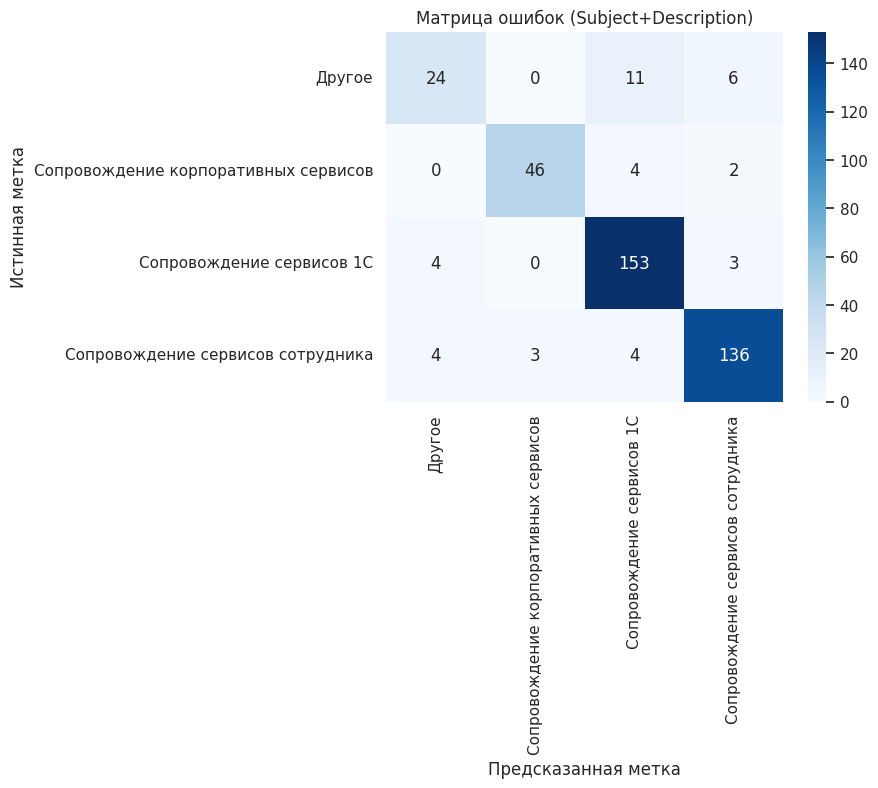

In [60]:
logger.info("Эксперимент 4: Subject + Description")
best_model_subj_desc, X_test, y_test, y_pred, y_proba = run_experiment(
    X_subj_desc, y, exp_name="Subject+Description"
)
run_eval(
    best_model_subj_desc,
    X_test,
    y_test,
    y_pred,
    y_proba,
    exp_name="Subject+Description",
)

In [78]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder


####################################
# Функция для проведения эксперимента с KNN (с LabelEncoder)
####################################
def run_experiment(X_emb, y, exp_name="Experiment"):
    # Преобразуем строковые метки в числовые
    label_encoder = LabelEncoder()
    y_enc = label_encoder.fit_transform(y)

    # Разбиваем данные на обучающую и тестовую выборки (с сохранением пропорций классов)
    X_train, X_test, y_train_enc, y_test_enc = train_test_split(
        X_emb, y_enc, test_size=0.2, random_state=42, stratify=y_enc
    )

    # Расширенный набор параметров для KNN
    param_grid_knn = {
        "n_neighbors": list(range(3, 21, 2)),  # от 3 до 19 с шагом 2
        "weights": ["uniform", "distance"],
        "p": [1, 2],  # 1: Manhattan, 2: Euclidean (для Minkowski)
        "algorithm": ["ball_tree", "kd_tree"],
        "leaf_size": [20, 30, 40, 50],
        "metric": ["minkowski", "euclidean", "manhattan"],
    }

    clf = KNeighborsClassifier()

    # Используем StratifiedKFold для сохранения пропорций классов в каждом фолде
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid = RandomizedSearchCV(
        clf,
        param_grid_knn,
        cv=cv,
        scoring="f1_macro",
        n_jobs=5,
        verbose=1,
        n_iter=100,
        random_state=42,
    )

    grid.fit(X_train, y_train_enc)

    # Предсказания (в числовом формате)
    y_pred_enc = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)

    # Обратно преобразуем числовые метки в исходные строковые
    y_test_orig = label_encoder.inverse_transform(y_test_enc)
    y_pred_orig = label_encoder.inverse_transform(y_pred_enc)

    print(f"=== Отчёт по классификации ({exp_name}) ===")
    print(classification_report(y_test_orig, y_pred_orig))

    # Переназначим атрибут classes_ модели, чтобы он содержал исходные строковые метки
    best_model = grid.best_estimator_
    best_model.classes_ = label_encoder.inverse_transform(best_model.classes_)

    return best_model, X_test, y_test_orig, y_pred_orig, y_proba


2025-02-28 20:48:19,400 - INFO - Эксперимент 4: Subject + Description


Fitting 5 folds for each of 100 candidates, totalling 500 fits
=== Отчёт по классификации (Subject+Description) ===
                                      precision    recall  f1-score   support

                              Другое       0.83      0.59      0.69        41
Сопровождение корпоративных сервисов       0.94      0.88      0.91        52
           Сопровождение сервисов 1С       0.90      0.94      0.92       160
   Сопровождение сервисов сотрудника       0.90      0.95      0.93       147

                            accuracy                           0.90       400
                           macro avg       0.89      0.84      0.86       400
                        weighted avg       0.90      0.90      0.90       400



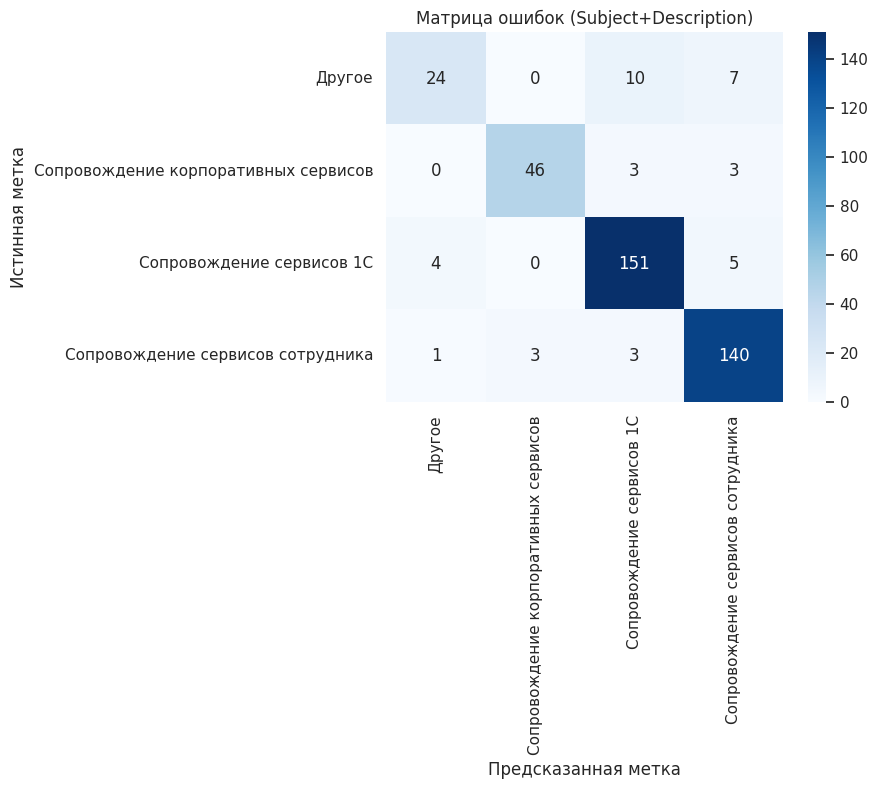

In [79]:
logger.info("Эксперимент 4: Subject + Description")
best_model_subj_desc, X_test, y_test, y_pred, y_proba = run_experiment(
    X_subj_desc, y, exp_name="Subject+Description"
)
run_eval(
    best_model_subj_desc,
    X_test,
    y_test,
    y_pred,
    y_proba,
    exp_name="Subject+Description",
)

In [82]:
best_model_subj_desc

KNeighborsClassifier(algorithm='ball_tree', leaf_size=40, metric='manhattan',
                     n_neighbors=7, weights='distance')

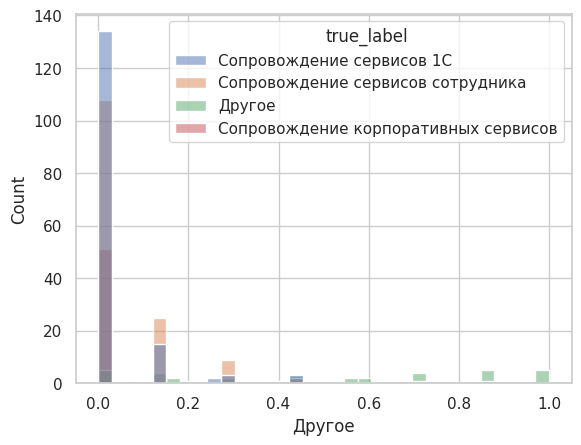

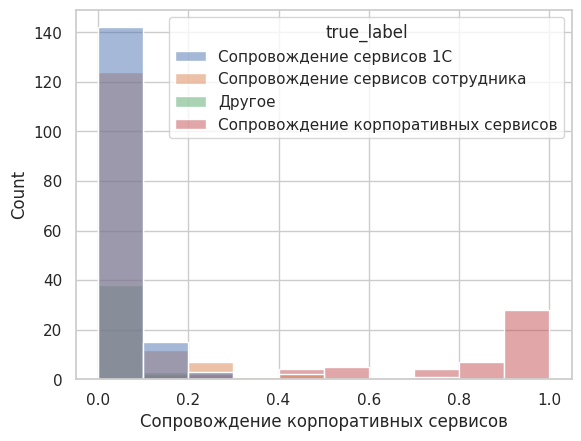

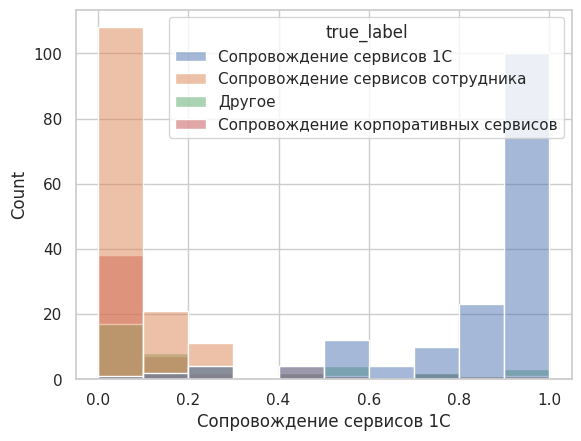

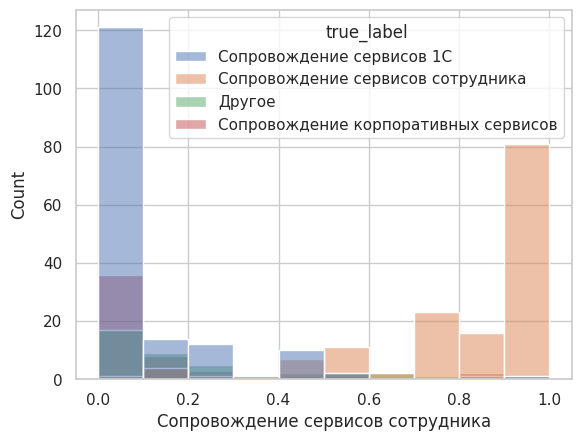

In [81]:
# Извлекаем список классов (предполагается, что порядок столбцов в y_proba соответствует best_estimator.classes_)
classes = best_model_subj_desc.classes_

# Создаем DataFrame с вероятностями, добавляя истинную метку
df_probs = pd.DataFrame(y_proba, columns=classes)
df_probs["true_label"] = y_test

for name in classes:
    sns.histplot(df_probs, x=name, hue="true_label")
    plt.show()

In [88]:
df_probs[df_probs[classes[2]] > 0.5]

,Другое,Сопровождение корпоративных сервисов,Сопровождение сервисов 1С,Сопровождение сервисов сотрудника,true_label
0,0.142180,0.000000,0.857820,0.000000,Сопровождение сервисов 1С
6,0.000000,0.000000,1.000000,0.000000,Сопровождение сервисов 1С
11,0.000000,0.000000,0.713501,0.286499,Другое
13,0.000000,0.000000,1.000000,0.000000,Сопровождение сервисов 1С
14,0.136483,0.000000,0.863517,0.000000,Сопровождение сервисов 1С
...,...,...,...,...,...
387,0.000000,0.143198,0.856802,0.000000,Сопровождение сервисов 1С
389,0.000000,0.000000,1.000000,0.000000,Сопровождение сервисов 1С
395,0.250907,0.000000,0.749093,0.000000,Сопровождение сервисов 1С
396,0.141155,0.000000,0.574205,0.284640,Сопровождение сервисов сотрудника


In [ ]:
import numpy as np
import pandas as pd

# Предполагается, что исходные данные:
# data – DataFrame с колонкой "description"
# y – метки классов (массив или Series)
# description_embeddings – numpy-массив эмбеддингов (соответствуют строкам data)

# Фильтруем строки, где description равен "no_description"
mask = data["description"] != "no_description"
data_filtered = data[mask].reset_index(drop=True)
description_embeddings_filtered = description_embeddings[mask]
# Если y – numpy-массив, можно фильтровать так:
y_filtered = np.array(y)[mask]

# Используем отфильтрованные данные для поиска
df = data_filtered.copy()
y = y_filtered

# Получаем уникальные классы для многоклассовой классификации
unique_classes = np.unique(y)


# Функция поиска ближайших соседей с использованием FAISS
def search_opposite_class(query_embeddings, target_embeddings, topk=1):
    d = target_embeddings.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(target_embeddings)
    distances, indices = index.search(query_embeddings, topk)
    return distances, indices


# Количество ближайших соседей для поиска
topk = 5

results = []

# Для каждого класса рассматриваем формат "1 vs All":
for cls in unique_classes:
    # Выбираем индексы для текущего класса (запросы) и всех остальных (целевая группа)
    query_indices = np.where(y == cls)[0]
    target_indices = np.where(y != cls)[0]

    # Получаем эмбеддинги для запросов и для кандидатов
    query_embeddings = description_embeddings_filtered[query_indices]
    target_embeddings = description_embeddings_filtered[target_indices]

    logger.info(
        "Поиск похожих эмбеддингов для класса {} против всех остальных".format(cls)
    )
    distances, candidate_local_indices = search_opposite_class(
        query_embeddings, target_embeddings, topk=topk
    )

    # Преобразуем локальные индексы кандидатов в глобальные индексы
    for i, (dist_row, cand_indices) in enumerate(
        zip(distances, candidate_local_indices)
    ):
        query_global_idx = query_indices[i]
        global_cand_indices = [target_indices[cand] for cand in cand_indices]
        results.append((query_global_idx, global_cand_indices, dist_row.tolist()))

# Сортируем результаты по расстоянию первого кандидата (наименьшее расстояние = наиболее похожие)
results_sorted = sorted(results, key=lambda x: x[2][0])

# Собираем результаты в DataFrame для удобства анализа
res_data = []
for query_idx, cand_list, dist_list in results_sorted:
    for cand_idx, dist in zip(cand_list, dist_list):
        query_text = df.loc[query_idx, "description"]
        candidate_text = df.loc[cand_idx, "description"]
        query_class = y[query_idx]
        candidate_class = y[cand_idx]
        res_data.append(
            {
                "query_idx": query_idx,
                "candidate_idx": cand_idx,
                "distance": dist,
                "query_text": query_text,
                "candidate_text": candidate_text,
                "query_class": query_class,
                "candidate_class": candidate_class,
            }
        )

results_df = pd.DataFrame(res_data)

# Сохраняем результаты в CSV-файл
output_results_path = "../results/most_similar_multiclass_1vsall.csv"
results_df.to_csv(output_results_path, index=False)
logger.info(f"Результаты поиска похожих эмбеддингов сохранены в {output_results_path}")

# Выводим топ-10 наиболее похожих пар (с наименьшими расстояниями)
print("Топ-10 наиболее похожих пар (по описанию):")
print(results_df.sort_values("distance").head(10).to_string(index=False))


2025-02-28 21:03:12,746 - INFO - Поиск похожих эмбеддингов для класса Другое против всех остальных
2025-02-28 21:03:12,783 - INFO - Поиск похожих эмбеддингов для класса Сопровождение корпоративных сервисов против всех остальных
2025-02-28 21:03:12,810 - INFO - Поиск похожих эмбеддингов для класса Сопровождение сервисов 1С против всех остальных
2025-02-28 21:03:12,837 - INFO - Поиск похожих эмбеддингов для класса Сопровождение сервисов сотрудника против всех остальных
2025-02-28 21:03:13,170 - INFO - Результаты поиска похожих эмбеддингов сохранены в ../results/most_similar_multiclass_1vsall.csv


Топ-10 наиболее похожих пар (по описанию):
 query_idx  candidate_idx  distance                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            query_text                                                                                                                                                                                                                                                                                                                                                                                                    

In [95]:
df

,Unnamed: 0,description,subject,class
0,0,Удалить старые версии 1С клиента на пк коменда...,Старая версия 1С клиента. Садовники д.4 к.2,Сопровождение сервисов сотрудника
1,1,Добрый день!\nОчень прошу Вас восстановить дос...,Восстановление доступа в личный кабинет препод...,Сопровождение сервисов сотрудника
2,2,Составить акт осмотра неисправного и\или морал...,Составить акт осмотра неисправного и\или морал...,Сопровождение сервисов сотрудника
3,3,"Добрый день, помогите, пожалуйста, сменить пар...",Смена пароль от учетной записи,Сопровождение сервисов сотрудника
4,4,необходимо установить web-агент Directum на ПК,Установка дополнительного стандартного ПО,Сопровождение сервисов сотрудника
...,...,...,...,...
1980,1995,"добрый день, система не дает выбрать дату пода...",Проблема с ЛК студента,Другое
1981,1996,Доброе утро!\n\nЗаявка на справку 0023181 от 2...,МФЦ КАС справка о стипендии,Сопровождение сервисов 1С
1982,1997,"\n-- \n С уважением,\n Акимова Валент...","ПРОШУ предоставить права ,необходимо распечат...",Сопровождение сервисов 1С
1983,1998,Добрый день!\n\nЗаявка на справку 0023207 от 2...,МФЦ КАС даты обучения,Сопровождение сервисов 1С


In [ ]:
import pandas as pd

output_results_path = "../results/most_similar_multiclass_1vsall.csv"


results_df = pd.read_csv(output_results_path)
# logger.info(f"Результаты поиска похожих эмбеддингов сохранены в {output_results_path}")

# Выводим топ-10 наиболее похожих пар (с наименьшими расстояниями)
print("Топ-10 наиболее похожих пар (по описанию):")
print(results_df.sort_values("distance").head(10).to_string(index=False))


Топ-10 наиболее похожих пар (по описанию):
 query_idx  candidate_idx  distance                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            query_text                                                                                                                                                                                                                                                                                                                                                                                                    

In [10]:
results_df["pair_id"] = results_df.apply(
    lambda x: set((x["query_idx"], x["candidate_idx"])), axis=1
)

In [ ]:
results_df.drop_duplicates("pair_id")

,query_idx,candidate_idx,distance,query_text,candidate_text,query_class,candidate_class,pair_id
0,1829,1970,2.974365,Здравствуйте!\nПрошу разблокировать корпоратив...,Здравствуйте1\nПрошу разблокировать корпоратив...,Другое,Сопровождение сервисов 1С,"{1970, 1829}"
1,1829,761,146.544434,Здравствуйте!\nПрошу разблокировать корпоратив...,Добрый день!\nПрошу Вас восстановить доступ к ...,Другое,Сопровождение сервисов сотрудника,"{761, 1829}"
2,1829,513,148.153442,Здравствуйте!\nПрошу разблокировать корпоратив...,"Добрый день, уважаемые коллеги.\nПомогите пожа...",Другое,Сопровождение сервисов сотрудника,"{513, 1829}"
3,1829,1160,159.426392,Здравствуйте!\nПрошу разблокировать корпоратив...,Добрый день!\nПоступило обращение от нескольки...,Другое,Сопровождение сервисов 1С,"{1160, 1829}"
4,1829,249,168.905762,Здравствуйте!\nПрошу разблокировать корпоратив...,"Добрый день, уважаемые коллеги!\nПросьба оказа...",Другое,Сопровождение сервисов сотрудника,"{249, 1829}"
...,...,...,...,...,...,...,...,...
9920,103,812,337.463745,\n,https://pyrus.com/t#id268344393,Сопровождение сервисов сотрудника,Сопровождение корпоративных сервисов,"{812, 103}"
9921,103,918,341.172241,\n,https://pyrus.com/t#id267267418?commentId=2345...,Сопровождение сервисов сотрудника,Сопровождение корпоративных сервисов,"{918, 103}"
9922,103,782,343.201782,\n,https://pyrus.com/t#id267510003,Сопровождение сервисов сотрудника,Сопровождение корпоративных сервисов,"{782, 103}"
9923,103,811,344.158936,\n,https://pyrus.com/t#id266266425,Сопровождение сервисов сотрудника,Сопровождение корпоративных сервисов,"{811, 103}"


In [4]:
results_df.sort_values("distance").head(100)

,query_idx,candidate_idx,distance,query_text,candidate_text,query_class,candidate_class
0,1829,1970,2.974365,Здравствуйте!\nПрошу разблокировать корпоратив...,Здравствуйте1\nПрошу разблокировать корпоратив...,Другое,Сопровождение сервисов 1С
5,1970,1829,2.974365,Здравствуйте1\nПрошу разблокировать корпоратив...,Здравствуйте!\nПрошу разблокировать корпоратив...,Сопровождение сервисов 1С,Другое
15,704,1817,15.464233,Добрый день!\nКлючевой носитель получен.\nМое ...,Добрый день!\nКлючевой носитель получен.\nМое ...,Сопровождение сервисов сотрудника,Сопровождение сервисов 1С
10,1817,704,15.464233,Добрый день!\nКлючевой носитель получен.\nМое ...,Добрый день!\nКлючевой носитель получен.\nМое ...,Сопровождение сервисов 1С,Сопровождение сервисов сотрудника
20,449,1562,17.377441,Добрый день!\n \nПрошу установить приложение д...,Добрый день!\n \nПрошу установить приложение д...,Сопровождение сервисов сотрудника,Сопровождение сервисов 1С
...,...,...,...,...,...,...,...
330,69,944,124.019531,\n\nhttps://sign.kontur.ru/document?id=294957...,"Здравствуйте!\nДобавьте, пожалуйста, список пр...",Сопровождение сервисов сотрудника,Сопровождение корпоративных сервисов
325,944,69,124.019531,"Здравствуйте!\nДобавьте, пожалуйста, список пр...",\n\nhttps://sign.kontur.ru/document?id=294957...,Сопровождение корпоративных сервисов,Сопровождение сервисов сотрудника
335,1851,281,124.137207,Доброе утро. \nЯ в прошлый раз говорила с колл...,"+ help@\n- все\n \nУважаемые коллеги, добрый д...",Другое,Сопровождение сервисов сотрудника
340,281,1851,124.137207,"+ help@\n- все\n \nУважаемые коллеги, добрый д...",Доброе утро. \nЯ в прошлый раз говорила с колл...,Сопровождение сервисов сотрудника,Другое


1) Готовы посмотреть 100 обращений (собрать по номеру обращения)
2) API simple one -> service (classification) -> proba + class + threshold -> response
3) Попробовать классификацию назначения (услугах)

Встреча через неделю

# Соберем выборку для исправления